In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gensim

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd

res = [];count = 0
with open('data/training_label.txt', 'r' , encoding='utf-8') as fn:
    for line in fn:
        line=line.strip('\n')
        if line != "":
            line_list = str(line).split("+++$+++")
            line_list[1] = line_list[1].strip()
            res.append(line_list)
            count += 1
            if(count>=10000):
                break
train = pd.DataFrame(res, columns=["sentiment", "review"])

res = []
with open('data/testing_label.txt', 'r' , encoding='utf-8') as fn:
    for line in fn:
        line=line.strip('\n')
        if line != "":
            line_list = str(line).split("#####")
            line_list[1] = line_list[1].strip()
            res.append(line_list)
test = pd.DataFrame(res, columns=["sentiment", "review"])

#### Snowball stemmer

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import re


def preprocess(text, stem=True):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop:
            if stem:
                tokens.append(SnowballStemmer(language="english").stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/iebi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train.review = train.review.apply(lambda x: preprocess(x))
test.review = test.review.apply(lambda x: preprocess(x))

In [5]:
total = pd.concat([train.review, test.review], axis=0, ignore_index=True)

#### 製作單字文本

In [6]:
documents = [text.split() for text in total]

In [7]:
import gensim
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 5
w2v_model = gensim.models.word2vec.Word2Vec(
                                            size=W2V_SIZE, # 一次讀進去的單字量
                                            window=W2V_WINDOW, # 滑動視窗 一次抓幾個字
                                            min_count=W2V_MIN_COUNT, # 出現>min_count 才算進去
                                            workers=8)

In [8]:
w2v_model.build_vocab(documents)

In [9]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2028


In [10]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 3.4 s, sys: 28.5 ms, total: 3.43 s
Wall time: 1.27 s


(1668172, 2304672)

In [11]:
w2v_model.wv.most_similar("fuck")

[('right', 0.8152106404304504),
 ('hate', 0.7912353277206421),
 ('suck', 0.7899588942527771),
 ('poor', 0.7844423055648804),
 ('stomach', 0.7759532928466797),
 ('babi', 0.7739000916481018),
 ('truth', 0.7719790935516357),
 ('hurt', 0.7624375224113464),
 ('mad', 0.7620768547058105),
 ('watchin', 0.7601940035820007)]

In [12]:
%%time
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.review)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 10778
CPU times: user 107 ms, sys: 10.9 ms, total: 118 ms
Wall time: 105 ms


#### padding zero or truncate words

In [13]:
%%time
SEQUENCE_LENGTH = 300
x_train = pad_sequences(tokenizer.texts_to_sequences(train.review), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.review), maxlen=SEQUENCE_LENGTH)

CPU times: user 107 ms, sys: 3.75 ms, total: 110 ms
Wall time: 110 ms


#### string to integer

In [14]:
train.sentiment = train.sentiment.astype("int64")
test.sentiment = test.sentiment.astype("int64")

In [15]:
labels = train.sentiment.unique()
labels

array([1, 0])

#### LabelEncoder 但是好像沒啥效果

In [16]:
encoder = LabelEncoder()
encoder.fit(train.sentiment.tolist())

y_train = encoder.transform(train.sentiment.tolist())
y_test = encoder.transform(test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (10000, 300)
y_train (10000, 1)

x_test (90, 300)
y_test (90, 1)


#### 看看你的index

In [17]:
tokenizer.word_index.items()

dict_items([('go', 1), ('day', 2), ('get', 3), ('good', 4), ('like', 5), ('work', 6), ('love', 7), ('today', 8), ('time', 9), ('got', 10), ('one', 11), ('lol', 12), ('im', 13), ('u', 14), ('back', 15), ('miss', 16), ('know', 17), ('want', 18), ('thank', 19), ('see', 20), ('make', 21), ('think', 22), ('realli', 23), ('feel', 24), ('still', 25), ('night', 26), ('need', 27), ('hope', 28), ('2', 29), ('oh', 30), ('well', 31), ('watch', 32), ('look', 33), ('new', 34), ('home', 35), ('come', 36), ('sleep', 37), ('last', 38), ('twitter', 39), ('great', 40), ('much', 41), ('wish', 42), ('morn', 43), ('wait', 44), ('tomorrow', 45), ('sad', 46), ('3', 47), ('week', 48), ('tri', 49), ('right', 50), ('happi', 51), ('say', 52), ('haha', 53), ('follow', 54), ('bad', 55), ('fun', 56), ('sorri', 57), ('tonight', 58), ('hate', 59), ('would', 60), ('friend', 61), ('tweet', 62), ('better', 63), ('nice', 64), ('way', 65), ('though', 66), ('gonna', 67), ('take', 68), ('yeah', 69), ('peopl', 70), ('bed', 71

In [18]:
w2v_model.wv["hi"]

array([-0.03584047,  0.2807657 ,  0.02924607, -0.526445  ,  0.08547498,
       -0.33549127,  0.29497337,  0.6267962 , -0.10855846,  0.16100451,
       -0.2898612 , -0.0689952 ,  0.01794904,  0.24102296,  0.02359778,
        0.6336258 ,  0.16447718,  0.38169575,  0.9118304 ,  0.07397962,
       -0.30318543,  0.3084213 , -0.2843525 , -0.08361749, -0.22949402,
       -0.01906267,  0.1494212 ,  0.20607938, -0.1370538 ,  0.11167557,
       -0.1446795 ,  0.11158432,  0.18508027,  0.07754526, -0.10818149,
        0.24181308, -0.09373097, -0.02269357,  0.14646016,  0.47784236,
        0.13410445, -0.09963813,  0.01780302,  0.09916124,  0.05323216,
       -0.16791494, -0.00194704,  0.0368511 ,  0.09751365,  0.17030796,
        0.19359864, -0.10207712, -0.28474697, -0.03058618,  0.19761434,
        0.15270343, -0.10440241, -0.40264773,  0.11098551, -0.16417243,
        0.1703878 ,  0.15787041, -0.50929874,  0.07652219,  0.13357683,
        0.3100137 ,  0.50860196,  0.35921147,  0.2448638 , -0.30

In [19]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word] # 向量值給embedding_matrix
print(embedding_matrix.shape)

(10778, 300)


#### overfitting model

In [20]:
# model = Sequential()
# model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

#### LSTM

In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          3233400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,393,901
Trainable params: 160,501
Non-trainable params: 3,233,400
_________________________________________________________________


#### SimpleRNN

In [23]:
from keras.layers import SimpleRNN
model_RNN = Sequential()
model_RNN.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(100))
model_RNN.add(Dense(1, activation='sigmoid'))

model_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          3233400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,273,601
Trainable params: 40,201
Non-trainable params: 3,233,400
_________________________________________________________________


In [24]:
%%time
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
SEQUENCE_LENGTH = 300
EPOCHS = 30
BATCH_SIZE = 256
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)
#                     callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 5s 672us/step - loss: 0.6414 - accuracy: 0.6300 - val_loss: 0.6247 - val_accuracy: 0.6470
Epoch 2/30
8000/8000 [==============================] - 5s 608us/step - loss: 0.6156 - accuracy: 0.6580 - val_loss: 0.6070 - val_accuracy: 0.6605
Epoch 3/30
8000/8000 [==============================] - 5s 607us/step - loss: 0.6081 - accuracy: 0.6600 - val_loss: 0.6034 - val_accuracy: 0.6605
Epoch 4/30
8000/8000 [==============================] - 5s 607us/step - loss: 0.6049 - accuracy: 0.6662 - val_loss: 0.5967 - val_accuracy: 0.6690
Epoch 5/30
8000/8000 [==============================] - 5s 607us/step - loss: 0.6022 - accuracy: 0.6651 - val_loss: 0.5948 - val_accuracy: 0.6775
Epoch 6/30
8000/8000 [==============================] - 5s 604us/step - loss: 0.5983 - accuracy: 0.6733 - val_loss: 0.5878 - val_accuracy: 0.6775
Epoch 7/30
8000/8000 [==============================] - 5s 606us/step - loss

In [25]:
%%time
model_RNN.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
SEQUENCE_LENGTH = 300
EPOCHS = 30
BATCH_SIZE = 256
history_RNN = model_RNN.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)
#                     callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 3s 413us/step - loss: 0.6623 - accuracy: 0.6116 - val_loss: 0.6383 - val_accuracy: 0.6220
Epoch 2/30
8000/8000 [==============================] - 3s 384us/step - loss: 0.6297 - accuracy: 0.6370 - val_loss: 0.6195 - val_accuracy: 0.6440
Epoch 3/30
8000/8000 [==============================] - 3s 385us/step - loss: 0.6162 - accuracy: 0.6568 - val_loss: 0.6175 - val_accuracy: 0.6415
Epoch 4/30
8000/8000 [==============================] - 3s 383us/step - loss: 0.6055 - accuracy: 0.6665 - val_loss: 0.6128 - val_accuracy: 0.6565
Epoch 5/30
8000/8000 [==============================] - 3s 384us/step - loss: 0.6035 - accuracy: 0.6683 - val_loss: 0.6073 - val_accuracy: 0.6570
Epoch 6/30
8000/8000 [==============================] - 3s 383us/step - loss: 0.5961 - accuracy: 0.6737 - val_loss: 0.6050 - val_accuracy: 0.6660
Epoch 7/30
8000/8000 [==============================] - 3s 383us/step - loss

### Evaluate

In [26]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

90/90 [==============================] - 0s 602us/step

ACCURACY: 0.7555555701255798
LOSS: 0.5381515622138977
CPU times: user 113 ms, sys: 21.8 ms, total: 135 ms
Wall time: 56.5 ms


In [27]:
%%time
score = model_RNN.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

90/90 [==============================] - 0s 412us/step

ACCURACY: 0.6111111044883728
LOSS: 0.6173274517059326
CPU times: user 89.7 ms, sys: 0 ns, total: 89.7 ms
Wall time: 38.8 ms


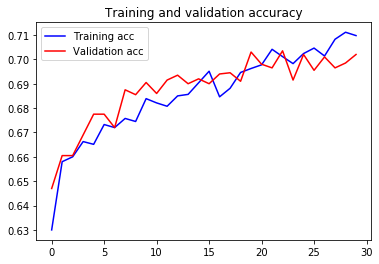

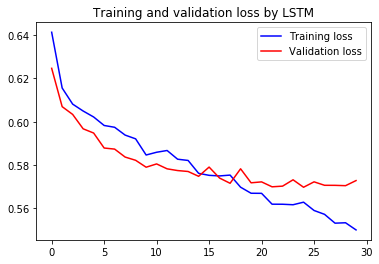

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss by LSTM')
plt.legend()
 
plt.show()

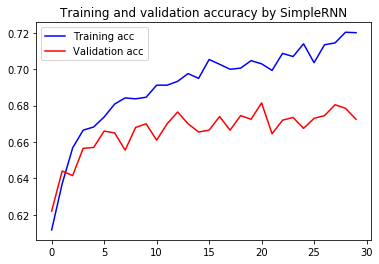

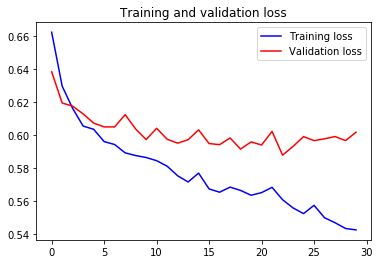

In [30]:
acc = history_RNN.history['accuracy']
val_acc = history_RNN.history['val_accuracy']
loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy by SimpleRNN')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()